In [39]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt


In [43]:
IMAGE_SIZE=256
BATCH_SIZE=32
EPOCHS=50
CHANNELS=3

In [5]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names=dataset.class_names
class_names


['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
len(dataset)

68

[1 1 0 0 2 0 0 0 2 0 1 1 1 0 0 0 1 0 1 1 0 1 0 0 0 1 0 1 1 0 1 1]
[1 1 0 0 2 0 0 0 2 0 1 1 1 0 0 0 1 0 1 1 0 1 0 0 0 1 0 1 1 0 1 1]
[1 1 0 0 2 0 0 0 2 0 1 1 1 0 0 0 1 0 1 1 0 1 0 0 0 1 0 1 1 0 1 1]
[1 1 0 0 2 0 0 0 2 0 1 1 1 0 0 0 1 0 1 1 0 1 0 0 0 1 0 1 1 0 1 1]
[1 1 0 0 2 0 0 0 2 0 1 1 1 0 0 0 1 0 1 1 0 1 0 0 0 1 0 1 1 0 1 1]
[1 1 0 0 2 0 0 0 2 0 1 1 1 0 0 0 1 0 1 1 0 1 0 0 0 1 0 1 1 0 1 1]
[1 1 0 0 2 0 0 0 2 0 1 1 1 0 0 0 1 0 1 1 0 1 0 0 0 1 0 1 1 0 1 1]
[1 1 0 0 2 0 0 0 2 0 1 1 1 0 0 0 1 0 1 1 0 1 0 0 0 1 0 1 1 0 1 1]
[1 1 0 0 2 0 0 0 2 0 1 1 1 0 0 0 1 0 1 1 0 1 0 0 0 1 0 1 1 0 1 1]
[1 1 0 0 2 0 0 0 2 0 1 1 1 0 0 0 1 0 1 1 0 1 0 0 0 1 0 1 1 0 1 1]
[1 1 0 0 2 0 0 0 2 0 1 1 1 0 0 0 1 0 1 1 0 1 0 0 0 1 0 1 1 0 1 1]
[1 1 0 0 2 0 0 0 2 0 1 1 1 0 0 0 1 0 1 1 0 1 0 0 0 1 0 1 1 0 1 1]


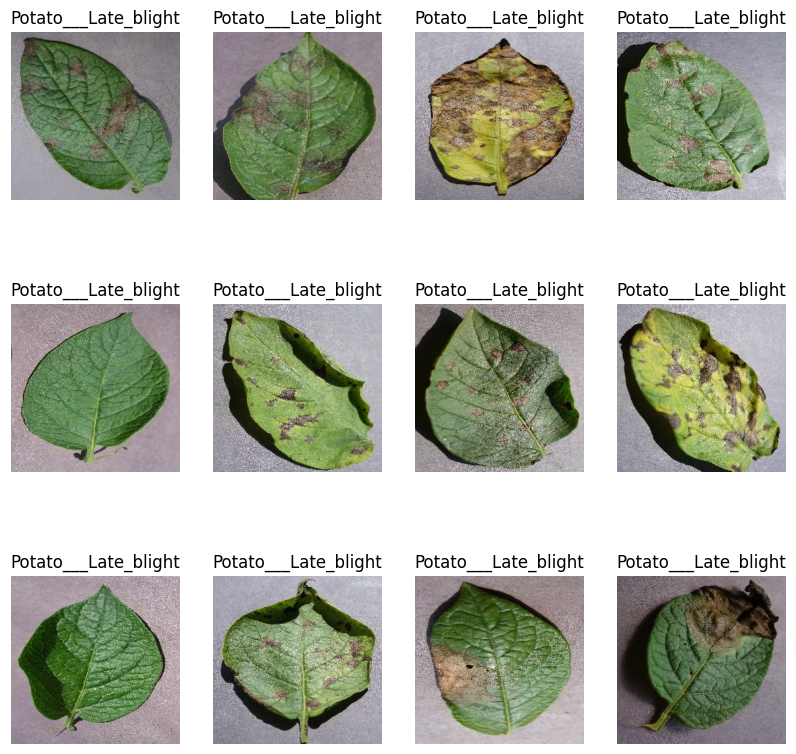

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3 , 4 ,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
        print(label_batch.numpy())

In [21]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [22]:
train_ds=dataset.take(54)
len(train_ds)

54

In [30]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [24]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [27]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [28]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [ ]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds) 
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [31]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [33]:
len(train_ds)

54

In [34]:
len(val_ds)

6

In [35]:
len(test_ds)

8

In [36]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [46]:
resized_and_rescale=tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [42]:
data_augmentation=data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [48]:
input_shape=(BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3

model=models.Sequential([
    resized_and_rescale,
    layers.Conv2D(32,(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

/home/malek/potatoDiseases/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [50]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [52]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50


I0000 00:00:1753545299.806537   59838 service.cc:152] XLA service 0x7f5ce0004540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753545299.808683   59838 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2025-07-26 16:55:00.009337: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753545300.593735   59838 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-07-26 16:55:02.032156: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.18 = (f32[32,32,254,254]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,256,256]{3,2,1,0} %bitcast.3945, f32[32,3,3,3]{3,2,1,0} %bitcast.3952, f32[32]{0} %bitcast.4799), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.4728 - loss: 0.9348

2025-07-26 16:55:27.538724: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:45: Filling up shuffle buffer (this may take a while): 26 of 10000
2025-07-26 16:55:27.786469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-26 16:55:27.787855: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-26 16:55:29.065762: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.18 = (f32[32,32,254,254]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,256,256]{3,2,1,0} %bitcast.891, f32[32,3,3,3]{3,2,1,0} %bitcast.898, f32[32]{0} %bitcast.900), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_4_1/conv2d_6_1/convolution" source_file="/home/malek/potatoDiseases/venv/lib/python3.12/site-packages/tensorf

54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 425ms/step - accuracy: 0.4731 - loss: 0.9344 - val_accuracy: 0.4375 - val_loss: 0.8949
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.6142 - loss: 0.7829 - val_accuracy: 0.7656 - val_loss: 0.4980
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.7677 - loss: 0.5368 - val_accuracy: 0.8438 - val_loss: 0.4085
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.8109 - loss: 0.4623 - val_accuracy: 0.8698 - val_loss: 0.3355
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.8550 - loss: 0.3774 - val_accuracy: 0.8958 - val_loss: 0.2660
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.8851 - loss: 0.2824 - val_accuracy: 0.9323 - val_loss: 0.1857
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.9263 - loss: 0.1973 - val_accuracy: 0.9010 - val_loss: 0.2244
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.9163 - loss: 0.2390 - val_accuracy: 0.9427 - val_loss:

In [53]:
scores=model.evaluate(test_ds)

2025-07-26 17:04:00.684914: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9855 - loss: 0.0826


In [54]:
scores

[0.03834765404462814, 0.9921875]

In [55]:
history

In [56]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [57]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [58]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

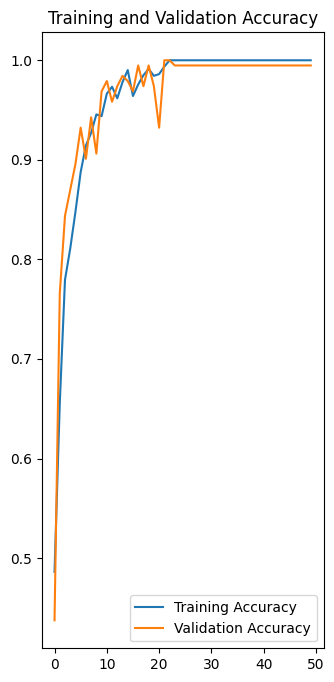

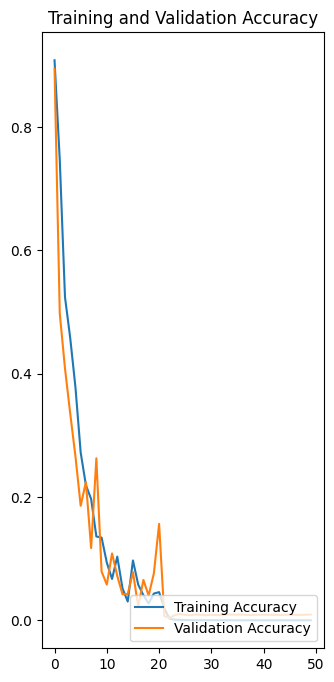

In [60]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),loss,label='Training Accuracy')
plt.plot(range(EPOCHS),val_loss, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

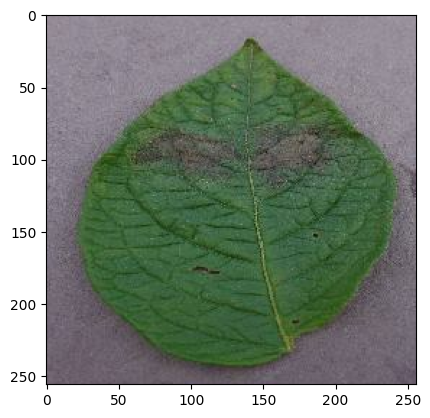

In [62]:
for image_batch, label_batch in test_ds.take(1):
    plt.imshow(image_batch[0].numpy().astype('uint8'))